# Data Exploration

This file's purpose is to aid in visualizing the data that was used to train and validate the model.

In [1]:
import datetime
now = datetime.datetime.now()
print("Last executed: " + now.strftime("%Y-%m-%d %H:%M:%S"))

Last executed: 2025-12-28 10:46:37


In [ ]:
# Initial imports
from __future__ import annotations
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# Find project root and add to path
PROJECT_ROOT = Path.cwd()
while not (PROJECT_ROOT / "src").exists() and PROJECT_ROOT != PROJECT_ROOT.parent:
    PROJECT_ROOT = PROJECT_ROOT.parent

SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

Some fool-proofing:

In [ ]:
# Import utilities (now that sys.path is set)
from data.g2net import load_labels, load_sample

# Point directly to the dataset on local disk (outside OneDrive)
DATASET_DIR = Path(r"D:\Programming\g2net-gravitational-wave-detection")
print("Using dataset from:", DATASET_DIR)

# Load labels
train_labels_df = load_labels(DATASET_DIR)

# Constants for plotting / spectrograms
FS = 2048                          # sampling rate (Hz)
N = 4096                           # samples per detector
T = np.arange(N) / FS              # time axis (s)
DETECTORS = ["Hanford (H1)", "Livingston (L1)", "Virgo (V1)"]

# Quick sanity prints
print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATASET_DIR:  ", DATASET_DIR)
print("Labels file:  ", (DATASET_DIR / "training_labels.csv"))
print("train_df:     ", train_labels_df.shape, "| target mean:", float(train_labels_df["target"].mean()))

In [4]:
from sklearn.model_selection import train_test_split

# We already have:
# train_labels_df = load_labels(DATASET_DIR)
# columns: ["id", "target"]

df = train_labels_df.copy()

# 1) Split into train and temp (val+test)
train_ids, temp_ids = train_test_split(
    df["id"],
    test_size=0.30,             # 30% will be val+test
    stratify=df["target"],      # keep class balance
    random_state=42,            # reproducible
)

train_df = df[df["id"].isin(train_ids)].reset_index(drop=True)
temp_df  = df[df["id"].isin(temp_ids)].reset_index(drop=True)

# 2) Split temp into val and test (each ~15% of total)
val_ids, test_ids = train_test_split(
    temp_df["id"],
    test_size=0.50,             # half of temp -> 15% overall
    stratify=temp_df["target"],
    random_state=42,
)

val_df  = df[df["id"].isin(val_ids)].reset_index(drop=True)
test_df = df[df["id"].isin(test_ids)].reset_index(drop=True)

# 3) Print how many instances are in each split
print(f"Total samples: {len(df)}")
print(f"Train samples: {len(train_df)}")
print(f"Val samples:   {len(val_df)}")
print(f"Test samples:  {len(test_df)}")


Total samples: 560000
Train samples: 392000
Val samples:   84000
Test samples:  84000


### Load Training Labels

The model we shall build will perform supervised classification on the G2Net Competition dataset. The labels for each training instance are stored in `training_labels.csv`, whose first 5 instances are shown below.


`training_labels.csv` contains two columns:
   - `id`: a unique identifier for each 2-second sample. It does *not* hold any information about the physical nature of the system (masses, spin, sky location, etc.)
   - `target`: the label (0 = noise-only, 1 = noise + simulated GW signal)

 The characters in the `id` are hexadecimal (0-9, a-f) and act as a unique key.
 The only information we can infer is:
   1) which sample it is (unique id),
   2) which subfolders it belongs to (first 3 characters),


In [5]:
train_labels_df.head()

,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1


We now check the first sample from `train_labels_df` and select its `id` and `target` values. We then use `load_sample` (defined in `g2net.py`) to retrieve the training sample that specific `id` points to.

In [6]:
sample_id = train_labels_df.iloc[0]['id']
target_value = train_labels_df.loc[train_labels_df['id'] == sample_id, 'target'].item()
sample = load_sample(sample_id)

print(f"Sample ID: \n {sample_id}")
print(f"Sample: \n {sample} -> notice it has 3 arrays, one for each detector")
print(f"Sample shape: \n {sample.shape} -> 3 detectors each with a 2s time series at 2048 Hz (4096 points)")
print("Is black hole?", "Yes!" if int(target_value) == 1 else "No :(")

Sample ID: 
 00000e74ad
Sample: 
 [[-5.94830548e-21 -5.84995448e-21 -5.42415169e-21 ... -6.06698987e-21
  -5.96345722e-21 -5.75778438e-21]
 [ 9.75407048e-22  4.52586118e-22  4.58643893e-23 ... -1.09608208e-20
  -1.09766636e-20 -1.10858129e-20]
 [-1.74871983e-21 -1.18286791e-21 -1.93223777e-21 ...  1.46502268e-21
   2.18644864e-21  1.54085934e-21]] -> notice it has 3 arrays, one for each detector
Sample shape: 
 (3, 4096) -> 3 detectors each with a 2s time series at 2048 Hz (4096 points)
Is black hole? Yes!


From the print statements above:

- 00000e74ad is the first file listed in `train_labels_df`. This, however, does not mean it is also the first item on \train\0\0\0, as the training labels file has been shuffled.
- the sample itself is a `numpy` array, with 3 other arrays contained within. Each of those arrays represents one of the LIGO detectors (Hanford, Livingston, and Virgo, respectively), each holding 4096 float values representing the 2-second signal itself.

The values inside `sample` themselves represent the *fractional change in arm length* the detector would experience due to a passing gravitational wave:

$$
h(t) = \frac{\Delta L}{L},
$$

where the sign indicates the direction of change.

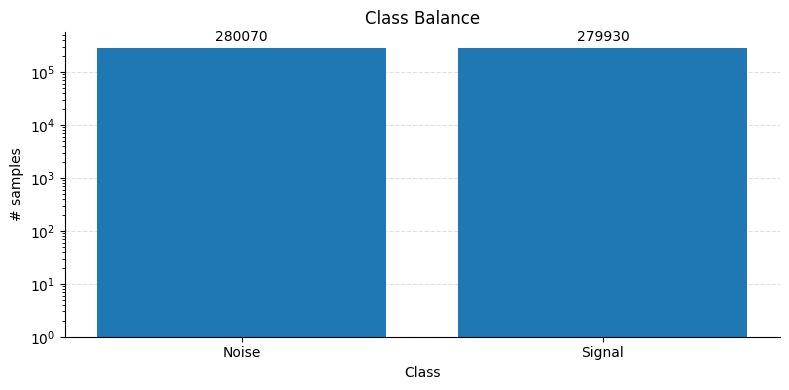

In [7]:
counts = train_labels_df["target"].value_counts().rename({0: "Noise", 1: "Signal"})
counts = counts.reindex(["Noise", "Signal"], fill_value=0)

labels = counts.index.tolist()
values = counts.values.tolist()

fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(labels, values)

ax.set_title("Class Balance")
ax.set_xlabel("Class")
ax.set_ylabel("# samples")

ax.set_yscale("log")          
ax.set_ylim(1, len(train_labels_df))   

ax.bar_label(bars, padding=3)
ax.grid(axis="y", linestyle="--", alpha=0.4)
ax.set_axisbelow(True)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


In [ ]:
# Import base model functions
from models.base_model import compute_features

# Define feature names
FEATURE_NAMES = []
for det in DETECTORS:
    FEATURE_NAMES += [
        f"{det}_mean",
        f"{det}_std",
        f"{det}_max_abs",
        f"{det}_rms",
    ]

# 5 bandas × 3 detetores = 15 (ordem: H1 bands, L1 bands, V1 bands)
for det in DETECTORS:
    for b in range(5):
        FEATURE_NAMES.append(f"{det}_band{b}_log_energy")

# 3 correlações (H–L, H–V, L–V)
FEATURE_NAMES += ["corr_H1_L1", "corr_H1_V1", "corr_L1_V1"]

# example: 100 samples per class
n_samples = 100
features = []

for label in [0, 1]:
    rows = train_labels_df[train_labels_df["target"] == label].sample(n_samples, random_state=0)

    for _, row in rows.iterrows():
        x = load_sample(row["id"])              # (3, 4096)
        feats_arr = compute_features(x)         # (30,)

        feats_dict = dict(zip(FEATURE_NAMES, feats_arr))
        feats_dict["target"] = label
        features.append(feats_dict)

features_df = pd.DataFrame(features)
features_df.head()

# Time-Series Evolution

In this section we explore one `sample` in more detail by plotting the strain vs time for all three detectors (H1, L1, V1).

For each detector we annotate:

1) **Peak strain time**  
   We mark the time index where the absolute strain reaches its maximum within the 2-second window.  
   In an ideal high-SNR detection, this peak tends to occur close to the merger time. In practice (especially at low SNR) the maximum can be influenced by noise, so this marker should be interpreted as a *useful visual reference*, not a guaranteed physical arrival time.  
   Still, comparing the peak times across detectors can provide intuition about relative delays (which, physically, are on the order of milliseconds).

2) **Frequency of maximum power**  
   We estimate the detector’s frequency content using a power spectral density (PSD) estimate. The **dominant frequency** is taken as the frequency bin with maximum PSD value in a chosen band (e.g., 8–24 Hz).

3) **Bandwidth around the dominant frequency**  
   We first create a spectrogram of the signal and use it tocompute a power-containment bandwidth. First, we sum the spectrogram power over time to obtain a single “power vs frequency” profile. We then normalise this profile so it behaves like a probability distribution across frequency, and select the central frequency interval [f_\min, f_\max] that contains a chosen fraction of the total power (90% by default). The bandwidth is reported as $f_{max}$ - $f_{min}$, giving a compact measure of how concentrated the energy is in frequency.

In [9]:
# time @ peak power
def time_peak_power(sample):
    instants = np.zeros(3)
    for det in range(len(sample)):
        instants[det] += np.argmax(np.abs(sample[det]))
    
    return instants
print(time_peak_power(sample))
# frequency @ peak power
def freq_peak_power(sample, fs=FS, nperseg=256, noverlap=192):
    frequencies = np.zeros(3)
    for det in range(3):
        # compute spectrogram to get frequency information
        f, t, Sxx = spectrogram(sample[det], fs=fs, nperseg=nperseg, 
                               noverlap=noverlap, scaling="density")
        
        # find frequency with maximum power (sum across all times)
        total_power_per_freq = Sxx.sum(axis=1)
        peak_freq_idx = np.argmax(total_power_per_freq)
        frequencies[det] = f[peak_freq_idx]
    
    return frequencies
print(freq_peak_power(sample))

def calculate_bandwidth(sample, power_threshold=0.99):
    """
    Calculate frequency bandwidth containing specified power fraction
    """
    bandwidths = np.zeros(3)
    min_freqs = np.zeros(3)
    max_freqs = np.zeros(3)
    
    for det in range(3):
        f, t, Sxx = spectrogram(sample[det], fs=FS, nperseg=256, noverlap=192)
        power_per_freq = Sxx.sum(axis=1)
        
        # normalize to create probability distribution
        power_normalized = power_per_freq / power_per_freq.sum()
        
        # sort by frequency (not power) for cumulative calculation
        sort_idx = np.argsort(f)
        f_sorted = f[sort_idx]
        power_sorted = power_normalized[sort_idx]
        
        # cumulative distribution
        cumulative = np.cumsum(power_sorted)
        
        # find frequencies containing the threshold power
        low_idx = np.argmax(cumulative >= (1 - power_threshold)/2)
        high_idx = np.argmax(cumulative >= (1 + power_threshold)/2)
        
        bandwidths[det] = f_sorted[high_idx] - f_sorted[low_idx]
        min_freqs[det] = f_sorted[low_idx]
        max_freqs[det] = f_sorted[high_idx]
    
    return bandwidths, min_freqs, max_freqs
bandwidths, min_freqs, max_freqs = calculate_bandwidth(sample)
for det in range(3):
    print(f"{DETECTORS[det]}: Bandwidth = {bandwidths[det]:.1f} Hz ({min_freqs[det]:.1f}-{max_freqs[det]:.1f} Hz)")

[2317. 1748. 1464.]
[8. 8. 8.]
Hanford (H1): Bandwidth = 24.0 Hz (8.0-32.0 Hz)
Livingston (L1): Bandwidth = 24.0 Hz (8.0-32.0 Hz)
Virgo (V1): Bandwidth = 744.0 Hz (8.0-752.0 Hz)


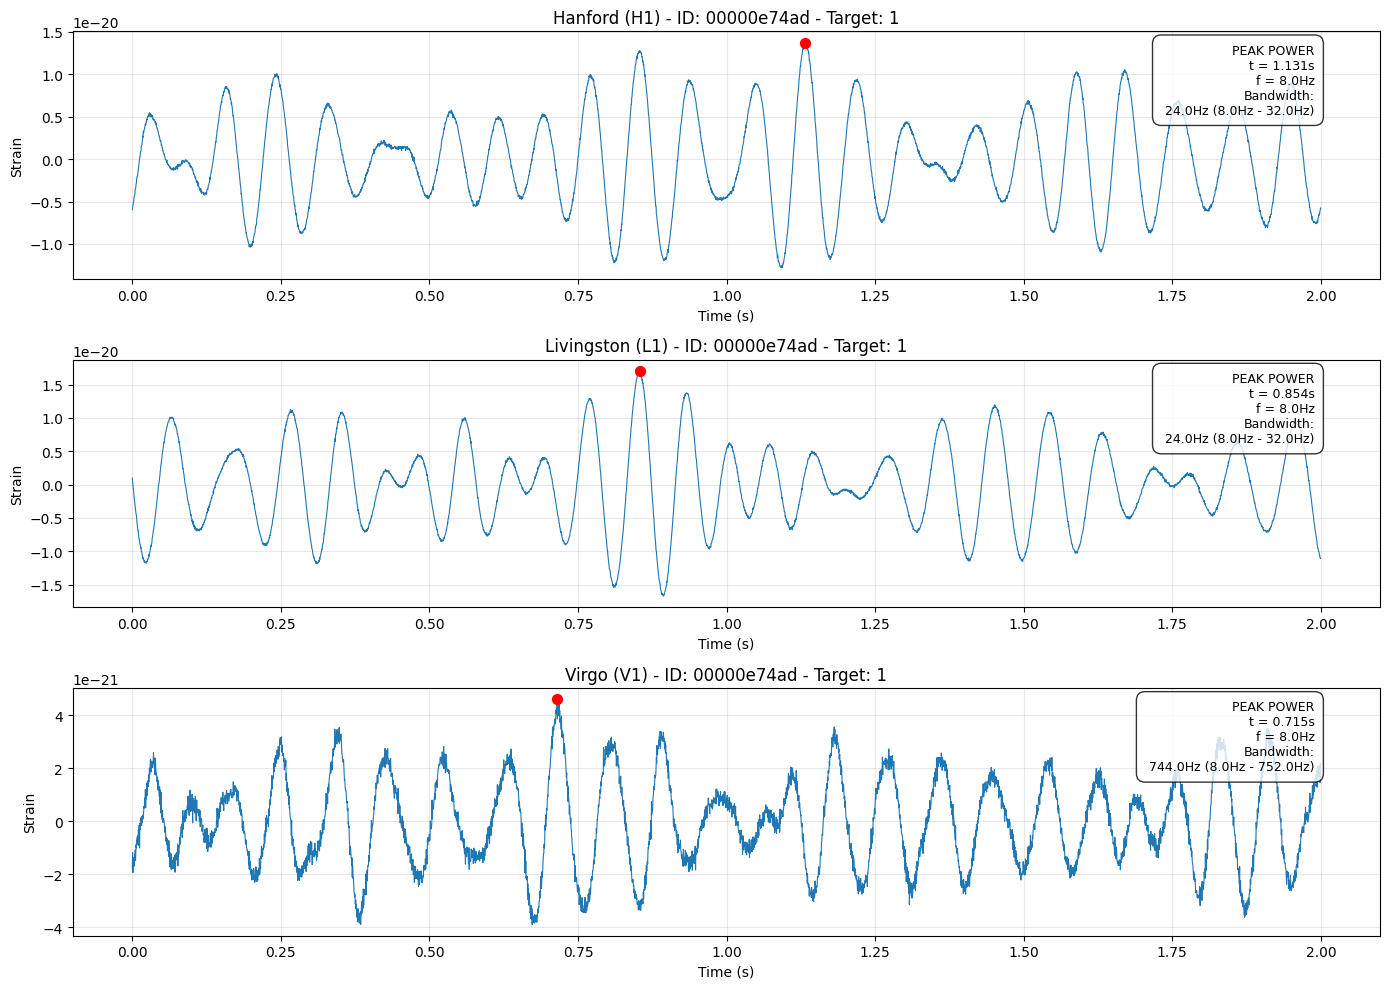

In [10]:
#visualize time series evolution

def plot_timeseries(sample, sample_id, target):
    # get peak information
    peak_times_idx = time_peak_power(sample)  
    peak_times = peak_times_idx / FS            
    peak_freqs = freq_peak_power(sample)           
    bandwidth = calculate_bandwidth(sample)
    
    plt.figure(figsize=(14, 10))
    
    for i in range(3):
        plt.subplot(3, 1, i+1)
        plt.plot(T, sample[i], linewidth=0.8)
        
        # get the actual peak value at that time
        peak_power = sample[i, int(peak_times_idx[i])]
        
        # mark the peak point with a red dot
        plt.scatter(peak_times[i], peak_power, color='red', s=50, zorder=5)
        
        plt.text(0.95, 0.95,
                f'PEAK POWER\nt = {peak_times[i]:.3f}s\nf = {peak_freqs[i]:.1f}Hz\nBandwidth:\n {bandwidth[0][i]}Hz ({bandwidth[1][i]}Hz - {bandwidth[2][i]}Hz)',
                transform=plt.gca().transAxes,  # use axis coordinates (0-1)
                bbox=dict(boxstyle="round,pad=0.7", facecolor="white", alpha=0.8),
                fontsize=9,
                ha='right',
                va='top')
        
        plt.title(f"{DETECTORS[i]} - ID: {sample_id} - Target: {target}")
        plt.xlabel("Time (s)")
        plt.ylabel("Strain")
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

target = train_labels_df.iloc[0]['target']
plot_timeseries(sample, sample_id, target)


# Spectrograms

[   0.    8.   16.   24.   32.   40.   48.   56.   64.   72.   80.   88.
   96.  104.  112.  120.  128.  136.  144.  152.  160.  168.  176.  184.
  192.  200.  208.  216.  224.  232.  240.  248.  256.  264.  272.  280.
  288.  296.  304.  312.  320.  328.  336.  344.  352.  360.  368.  376.
  384.  392.  400.  408.  416.  424.  432.  440.  448.  456.  464.  472.
  480.  488.  496.  504.  512.  520.  528.  536.  544.  552.  560.  568.
  576.  584.  592.  600.  608.  616.  624.  632.  640.  648.  656.  664.
  672.  680.  688.  696.  704.  712.  720.  728.  736.  744.  752.  760.
  768.  776.  784.  792.  800.  808.  816.  824.  832.  840.  848.  856.
  864.  872.  880.  888.  896.  904.  912.  920.  928.  936.  944.  952.
  960.  968.  976.  984.  992. 1000. 1008. 1016. 1024.]
[0.0625  0.09375 0.125   0.15625 0.1875  0.21875 0.25    0.28125 0.3125
 0.34375 0.375   0.40625 0.4375  0.46875 0.5     0.53125 0.5625  0.59375
 0.625   0.65625 0.6875  0.71875 0.75    0.78125 0.8125  0.84375 0.87

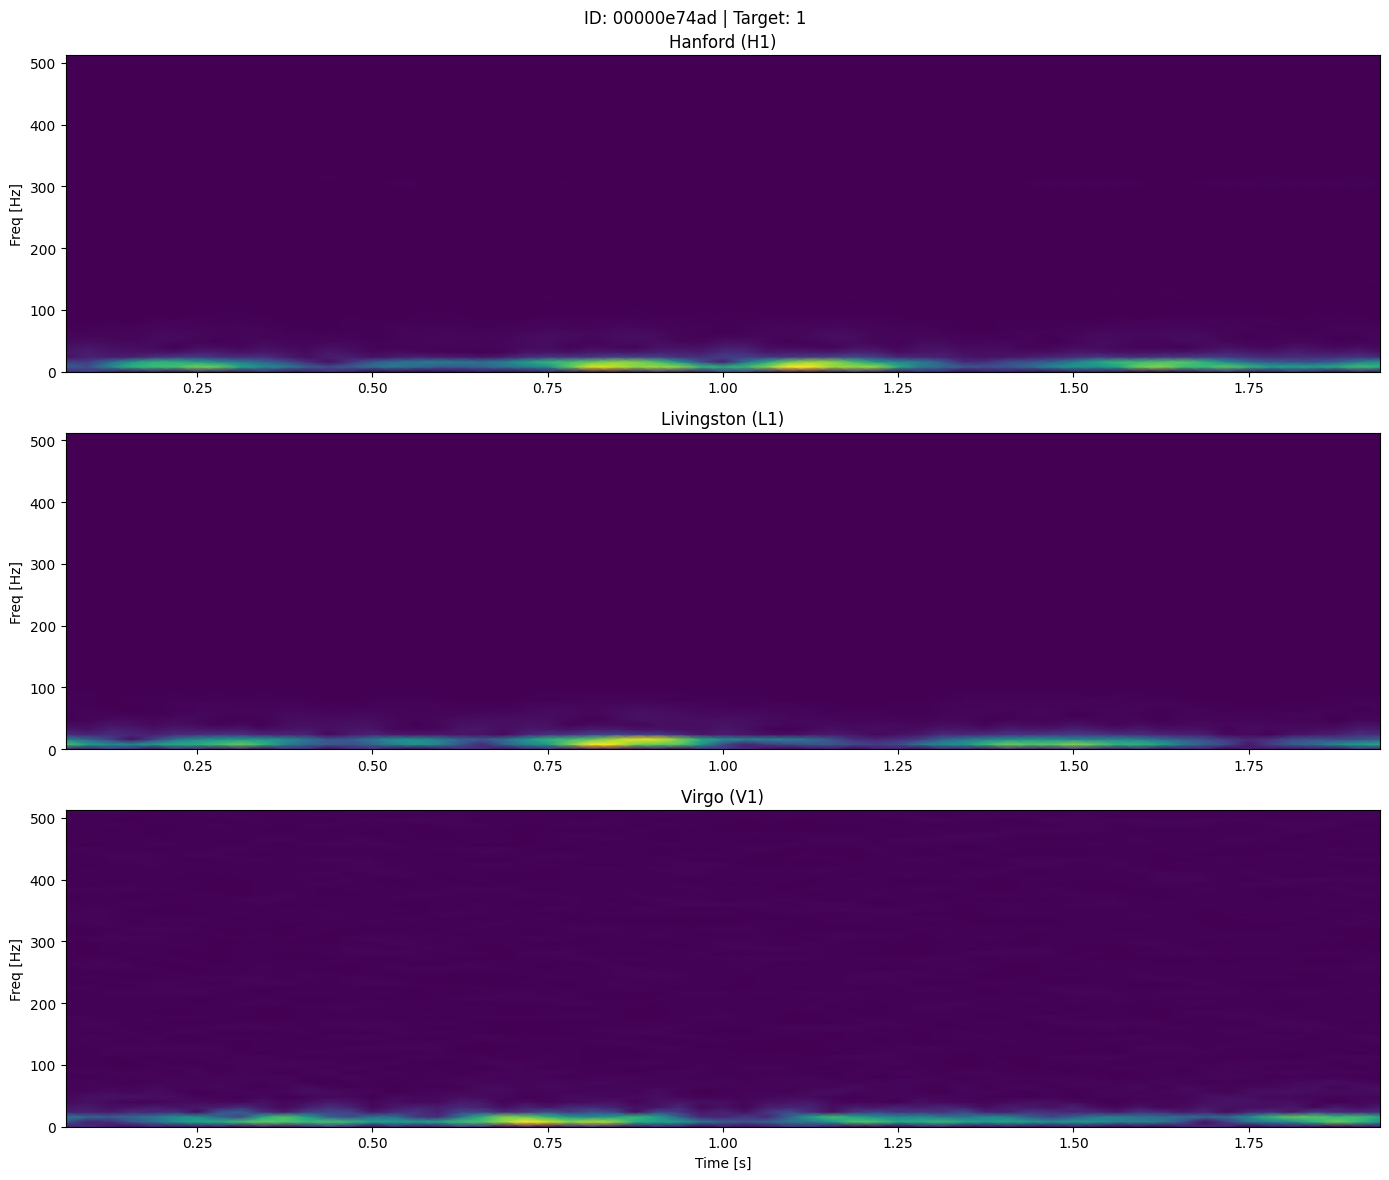

In [11]:
# spectrograms

def plot_spectrogram(x, det=0, fs=FS, nperseg=256, noverlap=192, fmax=512, title=None):
    """
    x: np.ndarray shape (3, 4096) or (4096,)
    det: detector index if x is (3, 4096)
    """
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    
    for det in range(3):
        sig = x[det]
        f, t, Sxx = spectrogram(sig, fs=fs, nperseg=nperseg, noverlap=noverlap, 
                               scaling="density", mode="magnitude")
        print(f)
        print(t)
        print(Sxx)
        if fmax is not None:
            m = f <= fmax
            f, Sxx = f[m], Sxx[m, :]

        axes[det].pcolormesh(t, f, 10*np.log10(Sxx + 1e-12), shading='gouraud')
        axes[det].set_ylabel("Freq [Hz]")
        axes[det].set_title(DETECTORS[det])
    
    axes[2].set_xlabel("Time [s]")
    fig.suptitle(title or "Spectrograms - All Detectors")
    plt.tight_layout()
    plt.show()

plot_spectrogram(sample, title=f"ID: {sample_id} | Target: {target}")


Sample: 28c7d331da, Target: 1


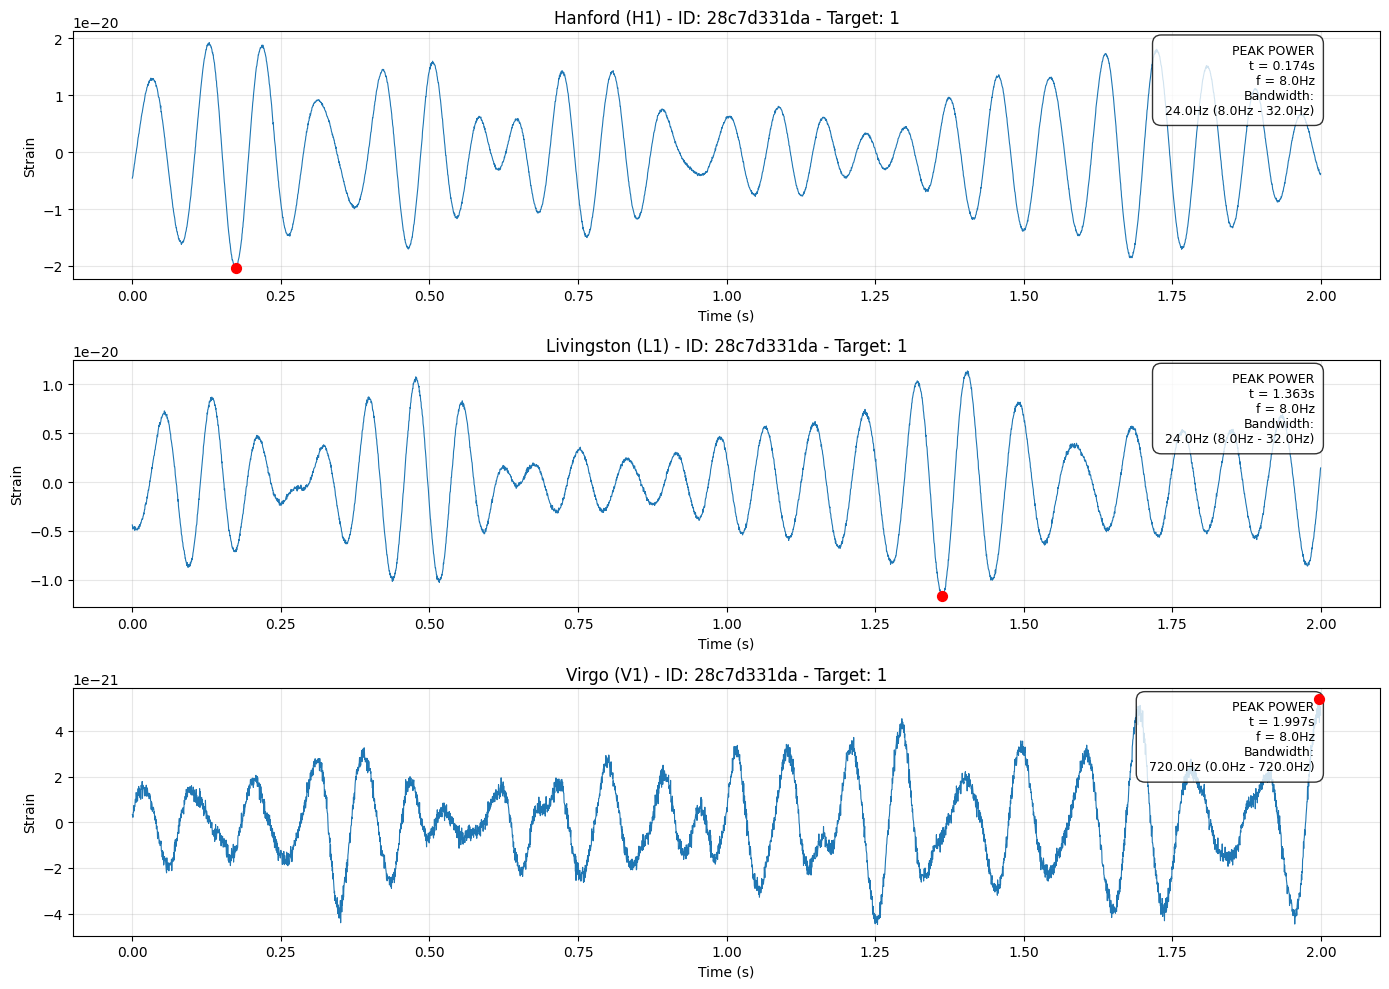

[   0.    8.   16.   24.   32.   40.   48.   56.   64.   72.   80.   88.
   96.  104.  112.  120.  128.  136.  144.  152.  160.  168.  176.  184.
  192.  200.  208.  216.  224.  232.  240.  248.  256.  264.  272.  280.
  288.  296.  304.  312.  320.  328.  336.  344.  352.  360.  368.  376.
  384.  392.  400.  408.  416.  424.  432.  440.  448.  456.  464.  472.
  480.  488.  496.  504.  512.  520.  528.  536.  544.  552.  560.  568.
  576.  584.  592.  600.  608.  616.  624.  632.  640.  648.  656.  664.
  672.  680.  688.  696.  704.  712.  720.  728.  736.  744.  752.  760.
  768.  776.  784.  792.  800.  808.  816.  824.  832.  840.  848.  856.
  864.  872.  880.  888.  896.  904.  912.  920.  928.  936.  944.  952.
  960.  968.  976.  984.  992. 1000. 1008. 1016. 1024.]
[0.0625  0.09375 0.125   0.15625 0.1875  0.21875 0.25    0.28125 0.3125
 0.34375 0.375   0.40625 0.4375  0.46875 0.5     0.53125 0.5625  0.59375
 0.625   0.65625 0.6875  0.71875 0.75    0.78125 0.8125  0.84375 0.87

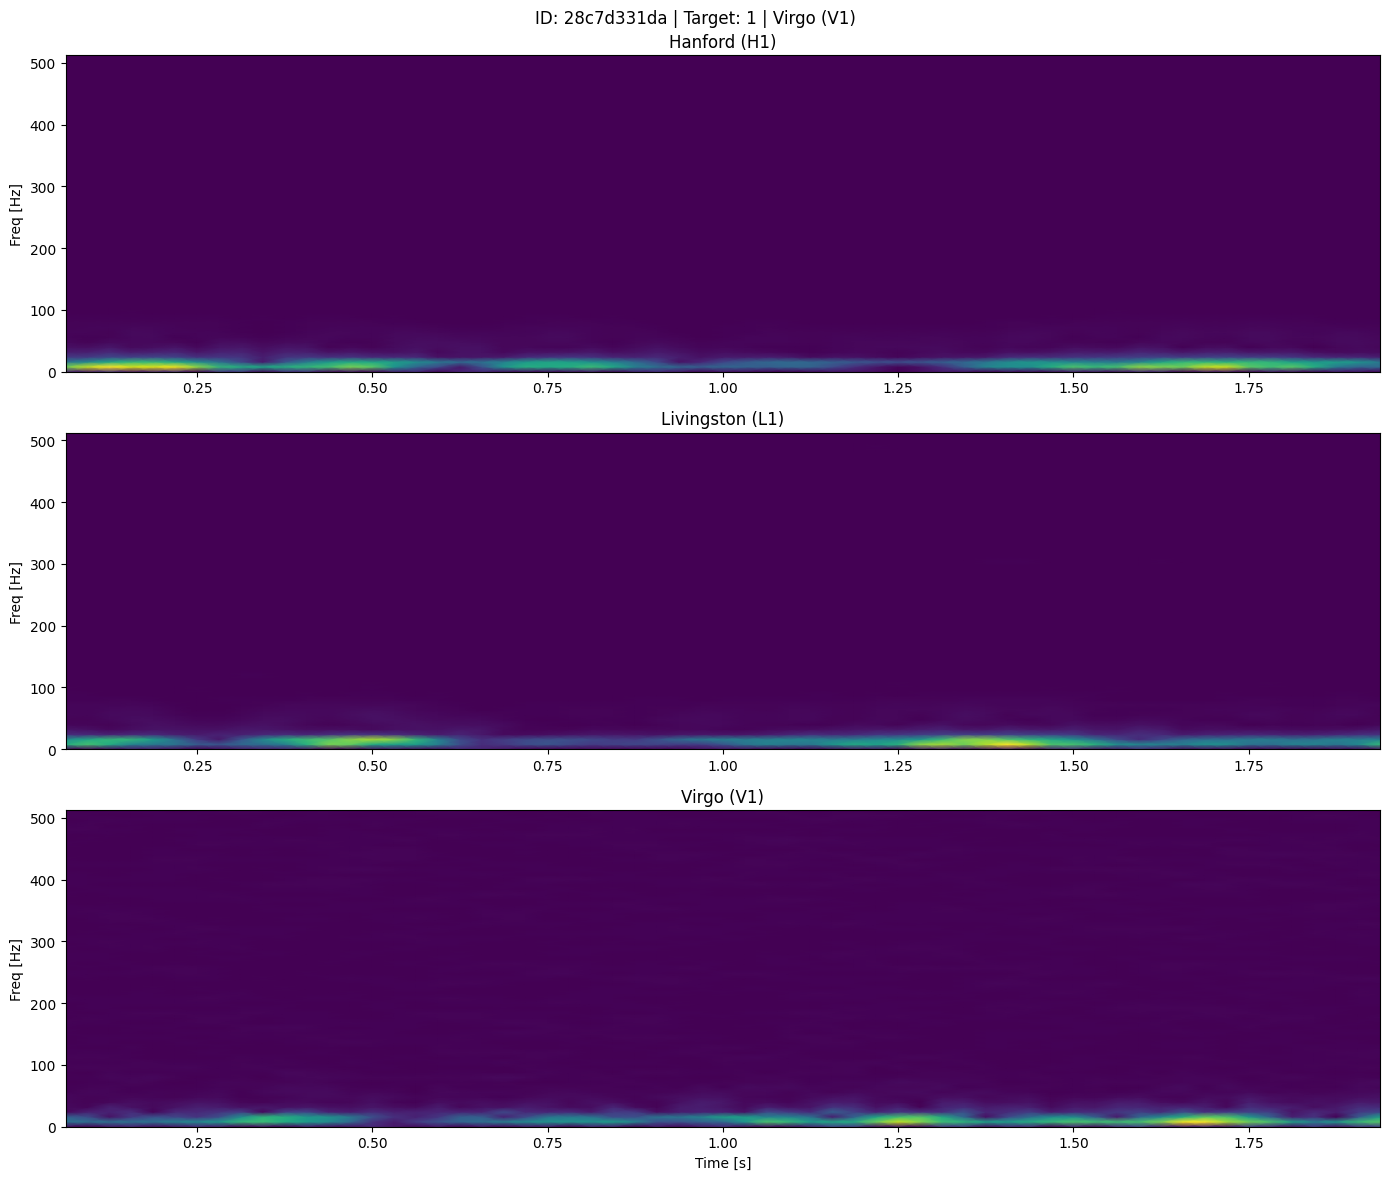

In [ ]:
# explore random samples

import random

def random_sample_vis():
    row = train_labels_df.sample(1).iloc[0]
    sample_id = row.id
    target = row.target
    data = load_sample(sample_id)
    
    print(f"Sample: {sample_id}, Target: {target}")
    plot_timeseries(data, sample_id, target)
    plot_spectrogram(data, det=det, title=f"ID: {sample_id} | Target: {target} | {DETECTORS[det]}")

random_sample_vis()